# GSOM VK project
## Read files from S3 with Spark

### 1. Libraries

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from datetime import datetime, timedelta
from pyspark.sql import udf
from pyspark.sql.types import *
from pyspark.sql.functions import struct
from pyspark.sql.functions import countDistinct
import multiprocessing
pd.set_option('display.max_columns', None)
N_CORES = min(
    multiprocessing.cpu_count(), 
    int(float(os.environ['CPU_LIMIT']))
)
print('max cores available:', N_CORES)

max cores available: 5


### 2. Credentials and Spark settings

In [2]:
BUCKET = 'rawdata-test-vk'
with open('access_vk.json') as file:
    access_data = json.load(file)

In [3]:
print('user:', os.environ['JUPYTERHUB_SERVICE_PREFIX'])

def uiWebUrl(self):
    from urllib.parse import urlparse
    web_url = self._jsc.sc().uiWebUrl().get()
    port = urlparse(web_url).port
    return '{}proxy/{}/jobs/'.format(os.environ['JUPYTERHUB_SERVICE_PREFIX'], port)

SparkContext.uiWebUrl = property(uiWebUrl)

conf = SparkConf()

conf.set('spark.master', 'local[*]')
conf.set('spark.driver.memory', '16G')
conf.set('spark.driver.maxResultSize', '4G')
sc = SparkContext(conf=conf)
spark = SparkSession(sc)
spark

user: /user/st055102/


23/06/01 17:22:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
spark._jsc.hadoopConfiguration().set('fs.s3a.access.key', access_data['aws_access_key_id'])
spark._jsc.hadoopConfiguration().set('fs.s3a.secret.key', access_data['aws_secret_access_key'])
spark._jsc.hadoopConfiguration().set('fs.s3a.impl','org.apache.hadoop.fs.s3a.S3AFileSystem')
spark._jsc.hadoopConfiguration().set('fs.s3a.multipart.size', '104857600')
spark._jsc.hadoopConfiguration().set('fs.s3a.block.size', '33554432')
spark._jsc.hadoopConfiguration().set('fs.s3a.threads.max', '256')
spark._jsc.hadoopConfiguration().set('fs.s3a.endpoint', 'http://storage.yandexcloud.net')
spark._jsc.hadoopConfiguration().set('fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')

### 3. Structure of the data

There are three groups in the bucket:
- gsom_abiturient
- gsom_ma
- gsom.spbu

Data is updated every week, last available data is (names of the folders):
- gsom_abiturient-2022-12-20-05-00-20-364747 (вторник)
- gsom_ma-2022-12-19-05-00-08-338606 (понедельник)
- gsom_spbu-2022-12-14-05-00-08-207227 (среда)

Structure in every folder is as follows:
- `/walls` folder with walls data of members oh the group
- `<GROUP_NAME>.json` (e.g.`gsom_abiturient.json`) file with the group description
- `members_full_group_<GROUP_NAME>.json` (e.g. `members_full_group_gsom_abiturient.json`) file with the full data for members of the group
- `members_group_<GROUP_NAME>.json` (e.g. `members_group_gsom_abiturient.json`) file with the list of group's members
- `wall_owner_id_<GROUP_ID>.json` (e.g. `wall_owner_id_23777199.json`) file with wall of the group

In [5]:
all_groups = [
    'gsom_abiturient',
    'gsom_ma',
    'gsom.spbu'
]

### 4. Read data examples

#### 4.1.Group info

In [6]:
file_path = f's3a://{BUCKET}/gsom_abiturient-2022-12-20*/gsom_abiturient.json'
print('file path to load:', file_path)
sdf = spark.read.json(file_path)

file path to load: s3a://rawdata-test-vk/gsom_abiturient-2022-12-20*/gsom_abiturient.json


23/06/01 17:22:22 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [7]:
sdf.printSchema()

root
 |-- activity: string (nullable = true)
 |-- addresses: struct (nullable = true)
 |    |-- count: long (nullable = true)
 |    |-- is_enabled: boolean (nullable = true)
 |    |-- main_address: struct (nullable = true)
 |    |    |-- address: string (nullable = true)
 |    |    |-- city: struct (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- title: string (nullable = true)
 |    |    |-- country: struct (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- title: string (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- title: string (nullable = true)
 |    |    |-- work_info_status: string (nullable = true)
 |    |-- main_address_id: long (nullable = true)
 |-- age_limits: long (nullable = true)
 |-- city: struct (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- title: string (nullable = true)
 |-- contacts: array (nullable = true)
 |    |-- element: struct (containsNull = tr

In [8]:
sdf.limit(5).toPandas()

23/06/01 17:22:27 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,activity,addresses,age_limits,city,contacts,counters,country,cover,crop_photo,description,has_photo,id,is_closed,links,main_album_id,main_section,market,members_count,name,photo_100,photo_200,photo_50,screen_name,site,status,trending,type,verified,wall,wiki_page
0,Open group,"(1, True, (Санкт-Петербургское шоссе 109, (2, ...",1,"(2, Санкт-Петербург)","[(Директор программ бакалавриата ВШМ СПбГУ, v....",[],"(1, Россия)","(1, [(67, https://sun1-85.userapi.com/impf/wkg...","((0.0, 100.0, 0.0, 100.0), (-6, 1653384382, Fa...","Все, что необходимо знать абитуриенту ВШМ СПбГ...",1,23777199,0,[(Официальная группа сообщества бизнес-школы №...,127539091,4,"(0, 0)",3307,Хочу учиться в ВШМ СПбГУ | Абитуриенту 2023,https://sun1-15.userapi.com/s/v1/ig2/TGZ9ny0RG...,https://sun1-15.userapi.com/s/v1/ig2/iWwUYZ04z...,https://sun1-15.userapi.com/s/v1/ig2/02taGqsGO...,gsom_abiturient,www.gsom.spbu.ru,Группа абитуриентов бакалавриата Высшей школы ...,0,group,0,2,Как поступить в 2023 году?


In [9]:
sdf.count()

1

#### 4.2. Members of the group

##### List of members

In [10]:
file_path = f's3a://{BUCKET}/gsom_abiturient-*/members_group_gsom_abiturient.json'
print('file path to load:', file_path)
sdf = spark.read.json(file_path)

file path to load: s3a://rawdata-test-vk/gsom_abiturient-*/members_group_gsom_abiturient.json


In [11]:
sdf.printSchema()

root
 |-- count: long (nullable = true)
 |-- items: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- next_from: string (nullable = true)



In [12]:
sdf.limit(10).toPandas()

,count,items,next_from
0,3434,"[959, 1361, 1642, 9088, 10615, 11738, 18619, 3...",PUkGEFNHDhJkUVhGBUk
1,3434,"[959, 1361, 1642, 9088, 10615, 11738, 18619, 3...",PUkGEFNHDhJkUVhGBUk
2,3433,"[959, 1361, 1642, 9088, 10615, 11738, 18619, 3...",PUkGEFNHDhJkUVhGBUk
3,3431,"[959, 1361, 1642, 9088, 10615, 11738, 18619, 3...",PUkGEFNHDhJkUVhGBUk
4,3431,"[959, 1361, 1642, 9088, 10615, 11738, 18619, 3...",PUkGEFNHDhJkUVhGBUk
5,3431,"[959, 1361, 1642, 9088, 10615, 11738, 18619, 3...",PUkGEFNHDhJkUVhGBUk
6,3424,"[959, 1361, 1642, 9088, 10615, 11738, 18619, 3...",PUkGEFNHDhJkUVhGBUk
7,3422,"[959, 1361, 1642, 9088, 10615, 11738, 18619, 3...",PUkGEFNHDhJkUVhGBUk
8,3418,"[959, 1361, 1642, 9088, 10615, 11738, 18619, 3...",PUkGEFNHDhJkUVhGBUk
9,3408,"[959, 1361, 1642, 9088, 10615, 11738, 18619, 3...",PUkGEFNHDhJkUVhGBUk


In [13]:
#sdf['items_set'] = sdf['items'].apply(lambda x: set(x.str.split(', ')))
#sdf['items_set'] = sdf['items'].map(lambda x: set(x.split(', ')))
#sdf['items_set'] = sdf['items'].apply(lambda x: set(item for s in x for item in s.split(', ')))
sdf

DataFrame[count: bigint, items: array<bigint>, next_from: string]

In [14]:
sdf1 = sdf.select(
    F.explode(sdf.items)
)
sdf1.printSchema()

root
 |-- col: long (nullable = true)



In [15]:
%%time
sdf1.count()

CPU times: user 59 µs, sys: 997 µs, total: 1.06 ms
Wall time: 560 ms


120312

In [16]:
sdf1.limit(10).toPandas()

,col
0,959
1,1361
2,1642
3,9088
4,10615
5,11738
6,18619
7,31053
8,37325
9,38445


## Detailed members info - для кластеринга

In [17]:
file_path = f's3a://{BUCKET}/gsom_abiturient-2023-05-23*/members_full_group_gsom_abiturient.json'
print('file path to load:', file_path)
sdf = spark.read.json(file_path)

file path to load: s3a://rawdata-test-vk/gsom_abiturient-2023-05-23*/members_full_group_gsom_abiturient.json


In [18]:
sdf.printSchema()

root
 |-- about: string (nullable = true)
 |-- activities: string (nullable = true)
 |-- bdate: string (nullable = true)
 |-- blacklisted: long (nullable = true)
 |-- blacklisted_by_me: long (nullable = true)
 |-- books: string (nullable = true)
 |-- can_access_closed: boolean (nullable = true)
 |-- can_post: long (nullable = true)
 |-- can_see_all_posts: long (nullable = true)
 |-- can_see_audio: long (nullable = true)
 |-- can_send_friend_request: long (nullable = true)
 |-- can_write_private_message: long (nullable = true)
 |-- career: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- city_id: long (nullable = true)
 |    |    |-- company: string (nullable = true)
 |    |    |-- country_id: long (nullable = true)
 |    |    |-- from: long (nullable = true)
 |    |    |-- group_id: long (nullable = true)
 |    |    |-- position: string (nullable = true)
 |    |    |-- until: long (nullable = true)
 |-- city: struct (nullable = true)
 |    |-- id: 

In [19]:
sdf.limit(5).toPandas()

,about,activities,bdate,blacklisted,blacklisted_by_me,books,can_access_closed,can_post,can_see_all_posts,can_see_audio,can_send_friend_request,can_write_private_message,career,city,country,crop_photo,deactivated,domain,education_form,education_status,facebook,facebook_name,faculty,faculty_name,first_name,followers_count,friend_status,games,graduation,has_mobile,has_photo,home_phone,home_town,id,instagram,interests,is_closed,is_friend,is_hidden_from_feed,is_no_index,last_name,last_seen,livejournal,maiden_name,mobile_phone,movies,music,nickname,occupation,online,online_app,online_mobile,personal,photo_100,photo_200,photo_200_orig,photo_400_orig,photo_50,photo_id,photo_max,photo_max_orig,quotes,relation,relation_partner,relatives,schools,screen_name,sex,site,skype,status,trending,tv,twitter,universities,university,university_name,verified,wall_default
0,None,None,25.4,0,0,None,True,0,0,0,0,0,None,"(2, Saint Petersburg)","(1, Russia)",None,None,id959,None,None,None,None,NaN,None,Anna,9199.0,0,None,NaN,1,1,None,None,959,None,None,False,0,0,True,Chaykina,"(4, 1684797617)",None,,None,None,None,,"(2, 1, 2009, 1, СПбГУ, university)",0,NaN,NaN,None,https://sun9-4.userapi.com/c14/u00959/d_320205...,https://sun9-4.userapi.com/c14/u00959/d_320205...,https://sun9-4.userapi.com/c14/u00959/a_292a27...,None,https://sun9-4.userapi.com/c14/u00959/e_fac3a9...,None,https://sun9-4.userapi.com/c14/u00959/d_320205...,https://sun9-4.userapi.com/c14/u00959/a_292a27...,None,NaN,None,None,None,id959,1,,None,,0,None,None,None,NaN,None,0,all
1,None,None,24.7.1983,0,0,None,True,0,0,0,1,0,None,"(2, Saint Petersburg)","(1, Russia)","((7.92, 84.17, 9.71, 82.56), (-6, 1655558440, ...",None,anna.veselova,None,None,None,None,NaN,None,Anna,891.0,0,None,NaN,1,1,None,None,1361,None,None,False,0,0,True,Veselova,"(2, 1684783948)",None,,None,None,None,,"(None, None, None, 25205856, Высшая школа экон...",0,NaN,NaN,None,https://sun1-20.userapi.com/s/v1/ig2/6o7pZr1l1...,https://sun1-20.userapi.com/s/v1/ig2/BY82Z29qI...,https://sun1-20.userapi.com/s/v1/ig2/BY82Z29qI...,https://sun1-20.userapi.com/s/v1/ig2/FjJAOLxhg...,https://sun1-20.userapi.com/s/v1/ig2/NwIDuSO0c...,1361_457239619,https://sun1-20.userapi.com/s/v1/ig2/FjJAOLxhg...,https://sun1-20.userapi.com/s/v1/ig2/FjJAOLxhg...,None,NaN,None,None,None,anna.veselova,1,http://vkontakte.ru/app638461_1361,ana_veselova,,0,None,None,None,NaN,None,0,all
2,Оказываю квалифицированную помощь гражданам и ...,"адвокатская, научно-педагогическая",31.8,0,0,Атлант расправил плечи; Мастер и Маргарита; Пр...,True,0,1,0,1,1,"[(2, SG ""Carrot & Line"", 1, 2007, None, Vice E...","(2, Saint Petersburg)","(1, Russia)","((0.0, 100.0, 0.0, 100.0), (-6, 1473959213, Fa...",None,id1642,Full-time,Alumnus (Bachelor's),None,None,19.0,Юридический факультет,Maxim,4089.0,0,Не играю,2010.0,1,1,None,Ленинград ----> Москва,1642,None,"Юриспруденция, авиация, театр, психология, фил...",False,0,0,False,Zavitkov,"(2, 1684775781)",None,None,+7 925 320 11 27,"Suits, Москва слезам не верит","Ленинград, С. Шнуров, Рубль, КиШ, Вася Обломов...",Advokat,"(None, None, None, None, Адвокатский кабинет З...",0,NaN,NaN,"{""alcohol"":0,""inspired_by"":"""",""langs"":[""Русски...",https://sun1-56.userapi.com/s/v1/if1/3y_U45fZG...,https://sun1-56.userapi.com/s/v1/if1/bgKDjzyqc...,https://sun1-56.userapi.com/s/v1/if1/zHSf92YDl...,https://sun1-56.userapi.com/s/v1/if1/6hsYuUu05...,https://sun1-56.userapi.com/s/v1/if1/DE3qU6SF2...,1642_431528789,https://sun1-56.userapi.com/s/v1/if1/7WX6u82kX...,https://sun1-56.userapi.com/s/v1/if1/6hsYuUu05...,"""Жизнь - это сложная штука, но эта сложная шту...",0.0,None,[],"[(2, в, 3, 1, 1125, Гимназия №426, гуманитарны...",id1642,2,,None,Квалифицированная юридическая помощь гражданам...,0,,None,"[(None, None, 2, 1, Full-time, 1, Alumnus (Bac...",1.0,СПбГУ,0,all
3,None,None,23.8.1989,0,0,None,True,0,0,1,1,1,None,"(2, Saint Petersburg)","(1, Russia)","((21.02, 81.09, 0.0, 90.1), (-6, 1606132898, F...",None,chezz,None,None,None,None,NaN,None,Serg

In [20]:
def flat_df(df, prefix=None):
    flat_cols = [c[0] for c in df.dtypes if c[1][:6] != 'struct']
    nested_cols = [c[0] for c in df.dtypes if c[1][:6] == 'struct']
    flat_df = df.select(
        flat_cols + 
        [F.col(ncol + '.' + col).alias(prefix + col if prefix else ncol + '_' + col ) 
         for ncol in nested_cols 
         for col in df.select(ncol + '.*').columns]
    )
    return flat_df

In [21]:
sdf = sdf.select(
    sdf.id,
    sdf.first_name,
    sdf.last_name,
    sdf.university_name,
    sdf.education_status,
    sdf.city,
    sdf.sex,
    sdf.interests,
    sdf.last_seen,
    sdf.bdate,
)
sdf = flat_df(sdf)
sdf.printSchema()

root
 |-- id: long (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- university_name: string (nullable = true)
 |-- education_status: string (nullable = true)
 |-- sex: long (nullable = true)
 |-- interests: string (nullable = true)
 |-- bdate: string (nullable = true)
 |-- city_id: long (nullable = true)
 |-- city_title: string (nullable = true)
 |-- last_seen_platform: long (nullable = true)
 |-- last_seen_time: long (nullable = true)



In [22]:
sdf.limit(5).toPandas()

,id,first_name,last_name,university_name,education_status,sex,interests,bdate,city_id,city_title,last_seen_platform,last_seen_time
0,959,Anna,Chaykina,None,None,1,None,25.4,2,Saint Petersburg,4,1684797617
1,1361,Anna,Veselova,None,None,1,None,24.7.1983,2,Saint Petersburg,2,1684783948
2,1642,Maxim,Zavitkov,СПбГУ,Alumnus (Bachelor's),2,"Юриспруденция, авиация, театр, психология, фил...",31.8,2,Saint Petersburg,2,1684775781
3,9088,Sergey,Cherepanov,None,None,2,None,23.8.1989,2,Saint Petersburg,4,1684791456
4,10615,Darya,Lebedeva,None,None,1,None,15.8,2,Saint Petersburg,2,1684784820


In [23]:
df = sdf.toPandas()

In [24]:
df

,id,first_name,last_name,university_name,education_status,sex,interests,bdate,city_id,city_title,last_seen_platform,last_seen_time
0,959,Anna,Chaykina,None,None,1,None,25.4,2.0,Saint Petersburg,4.0,1.684798e+09
1,1361,Anna,Veselova,None,None,1,None,24.7.1983,2.0,Saint Petersburg,2.0,1.684784e+09
2,1642,Maxim,Zavitkov,СПбГУ,Alumnus (Bachelor's),2,"Юриспруденция, авиация, театр, психология, фил...",31.8,2.0,Saint Petersburg,2.0,1.684776e+09
3,9088,Sergey,Cherepanov,None,None,2,None,23.8.1989,2.0,Saint Petersburg,4.0,1.684791e+09
4,10615,Darya,Lebedeva,None,None,1,None,15.8,2.0,Saint Petersburg,2.0,1.684785e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
3426,757131621,Natalya,Mishulina,,None,1,,1.7.2005,NaN,None,4.0,1.684781e+09
3427,776095130,Rudi,Troya,None,None,2,None,21.1.2000,NaN,None,7.0,1.684624e+09
3428,787319478,Valeria,Shevchenko,,None,1,,30.3.2006,NaN,None,2.0,1.684788e+09
3429,787549222,Simona,Petrova,,None,1,,7.8.2008,2.0,Saint Petersburg,7.0,1.680514e+09


In [25]:
from datetime import datetime, timedelta

In [26]:
#df['last_seen_time'] = pd.to_datetime(df.last_seen_time, format='%Y-%m-%d %H:%M:%S')
#df['last_seen_time'] = df['last_seen_time'] + timedelta(hours=3)

In [27]:
df['last_seen_time'] = pd.to_datetime(df['last_seen_time'],unit='s')

In [28]:
df

,id,first_name,last_name,university_name,education_status,sex,interests,bdate,city_id,city_title,last_seen_platform,last_seen_time
0,959,Anna,Chaykina,None,None,1,None,25.4,2.0,Saint Petersburg,4.0,2023-05-22 23:20:17
1,1361,Anna,Veselova,None,None,1,None,24.7.1983,2.0,Saint Petersburg,2.0,2023-05-22 19:32:28
2,1642,Maxim,Zavitkov,СПбГУ,Alumnus (Bachelor's),2,"Юриспруденция, авиация, театр, психология, фил...",31.8,2.0,Saint Petersburg,2.0,2023-05-22 17:16:21
3,9088,Sergey,Cherepanov,None,None,2,None,23.8.1989,2.0,Saint Petersburg,4.0,2023-05-22 21:37:36
4,10615,Darya,Lebedeva,None,None,1,None,15.8,2.0,Saint Petersburg,2.0,2023-05-22 19:47:00
...,...,...,...,...,...,...,...,...,...,...,...,...
3426,757131621,Natalya,Mishulina,,None,1,,1.7.2005,NaN,None,4.0,2023-05-22 18:39:45
3427,776095130,Rudi,Troya,None,None,2,None,21.1.2000,NaN,None,7.0,2023-05-20 23:06:19
3428,787319478,Valeria,Shevchenko,,None,1,,30.3.2006,NaN,None,2.0,2023-05-22 20:43:42
3429,787549222,Simona,Petrova,,None,1,,7.8.2008,2.0,Saint Petersburg,7.0,2023-04-03 09:34:22


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3431 entries, 0 to 3430
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  3431 non-null   int64         
 1   first_name          3431 non-null   object        
 2   last_name           3431 non-null   object        
 3   university_name     904 non-null    object        
 4   education_status    192 non-null    object        
 5   sex                 3431 non-null   int64         
 6   interests           904 non-null    object        
 7   bdate               2729 non-null   object        
 8   city_id             2498 non-null   float64       
 9   city_title          2498 non-null   object        
 10  last_seen_platform  3029 non-null   float64       
 11  last_seen_time      3029 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 321.8+ KB


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3431 entries, 0 to 3430
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  3431 non-null   int64         
 1   first_name          3431 non-null   object        
 2   last_name           3431 non-null   object        
 3   university_name     904 non-null    object        
 4   education_status    192 non-null    object        
 5   sex                 3431 non-null   int64         
 6   interests           904 non-null    object        
 7   bdate               2729 non-null   object        
 8   city_id             2498 non-null   float64       
 9   city_title          2498 non-null   object        
 10  last_seen_platform  3029 non-null   float64       
 11  last_seen_time      3029 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 321.8+ KB


In [31]:
df.university_name.value_counts(dropna = True).loc[lambda x : x > 10]

                    405
СПбГУ               207
НИУ ВШЭ (СПб)        27
СПбГЭУ               17
НИУ ВШЭ (ГУ-ВШЭ)     11
Name: university_name, dtype: int64

In [32]:
df.to_csv('profile_info_gsom_bach.csv')

### магистратура, загрузка по пн

In [33]:
file_path = f's3a://{BUCKET}/gsom_ma-2023-05-22*/members_full_group_gsom_ma.json'
print('file path to load:', file_path)
sdf = spark.read.json(file_path)

file path to load: s3a://rawdata-test-vk/gsom_ma-2023-05-22*/members_full_group_gsom_ma.json


In [34]:
sdf = sdf.select(
    sdf.id,
    sdf.first_name,
    sdf.last_name,
    sdf.city,
    sdf.sex,
    sdf.interests,
    sdf.last_seen,
    sdf.bdate
)
sdf = flat_df(sdf)
sdf.printSchema()

root
 |-- id: long (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- sex: long (nullable = true)
 |-- interests: string (nullable = true)
 |-- bdate: string (nullable = true)
 |-- city_id: long (nullable = true)
 |-- city_title: string (nullable = true)
 |-- last_seen_platform: long (nullable = true)
 |-- last_seen_time: long (nullable = true)



In [35]:
df = sdf.toPandas()

In [36]:
from datetime import datetime, timedelta

In [37]:
df['last_seen_time'] = pd.to_datetime(df['last_seen_time'],unit='s')

In [38]:
df.to_csv('profile_info_gsom_ma.csv')

### общая группа - загрузка по средам

In [39]:
file_path = f's3a://{BUCKET}/gsom_spbu-2023-05-24*/members_full_group_gsom.spbu.json'
print('file path to load:', file_path)
sdf = spark.read.json(file_path)

file path to load: s3a://rawdata-test-vk/gsom_spbu-2023-05-24*/members_full_group_gsom.spbu.json


In [40]:
sdf = sdf.select(
    sdf.id,
    sdf.first_name,
    sdf.last_name,
    sdf.city,
    sdf.sex,
    sdf.interests,
    sdf.last_seen,
    sdf.bdate
)
sdf = flat_df(sdf)
sdf.printSchema()

root
 |-- id: long (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- sex: long (nullable = true)
 |-- interests: string (nullable = true)
 |-- bdate: string (nullable = true)
 |-- city_id: long (nullable = true)
 |-- city_title: string (nullable = true)
 |-- last_seen_platform: long (nullable = true)
 |-- last_seen_time: long (nullable = true)



In [41]:
df = sdf.toPandas()

In [42]:
from datetime import datetime, timedelta

In [43]:
df['last_seen_time'] = pd.to_datetime(df['last_seen_time'],unit='s')

In [44]:
df.to_csv('profile_info_gsom_spbu.csv')

In [45]:
## Euler-Vien Diagram по пересечению подписчиков

## 4.3. Walls data

In [47]:
file_path = f's3a://{BUCKET}/gsom_abiturient-2023-05-23*/wall_owner_id_*.json'
print('file path to load:', file_path)
sdf = spark.read.json(file_path)

file path to load: s3a://rawdata-test-vk/gsom_abiturient-2023-05-23*/wall_owner_id_*.json


In [48]:
sdf.count()

1

In [49]:
def flat_df(df, prefix=None):
    flat_cols = [c[0] for c in df.dtypes if c[1][:6] != 'struct']
    nested_cols = [c[0] for c in df.dtypes if c[1][:6] == 'struct']
    flat_df = df.select(
        flat_cols + 
        [F.col(ncol + '.' + col).alias(prefix + col if prefix else ncol + '_' + col ) 
         for ncol in nested_cols 
         for col in df.select(ncol + '.*').columns]
    )
    return flat_df

In [50]:
#sdf.printSchema()

In [51]:
sdf.limit(5).toPandas()

,count,groups,items,profiles
0,587,"[(168, 0, Высшая школа менеджмента СПбГУ, http...","[([], None, (1, 0, True), [Row(attachments=[Ro...","[(True, VK Administration, 100, False, , 0, (N..."


In [52]:
sdf = sdf.select(
    F.explode(sdf.items)
)
sdf.printSchema()

root
 |-- col: struct (nullable = true)
 |    |-- attachments: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- audio: struct (nullable = true)
 |    |    |    |    |-- artist: string (nullable = true)
 |    |    |    |    |-- date: long (nullable = true)
 |    |    |    |    |-- duration: long (nullable = true)
 |    |    |    |    |-- genre_id: long (nullable = true)
 |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |-- is_explicit: boolean (nullable = true)
 |    |    |    |    |-- is_focus_track: boolean (nullable = true)
 |    |    |    |    |-- owner_id: long (nullable = true)
 |    |    |    |    |-- short_videos_allowed: boolean (nullable = true)
 |    |    |    |    |-- stories_allowed: boolean (nullable = true)
 |    |    |    |    |-- stories_cover_allowed: boolean (nullable = true)
 |    |    |    |    |-- title: string (nullable = true)
 |    |    |    |    |-- track_code: string (nullable = true)
 |   

In [53]:
sdf = sdf.select(sdf.col)
sdf=flat_df(sdf)
sdf.printSchema()

root
 |-- col_attachments: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- audio: struct (nullable = true)
 |    |    |    |-- artist: string (nullable = true)
 |    |    |    |-- date: long (nullable = true)
 |    |    |    |-- duration: long (nullable = true)
 |    |    |    |-- genre_id: long (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- is_explicit: boolean (nullable = true)
 |    |    |    |-- is_focus_track: boolean (nullable = true)
 |    |    |    |-- owner_id: long (nullable = true)
 |    |    |    |-- short_videos_allowed: boolean (nullable = true)
 |    |    |    |-- stories_allowed: boolean (nullable = true)
 |    |    |    |-- stories_cover_allowed: boolean (nullable = true)
 |    |    |    |-- title: string (nullable = true)
 |    |    |    |-- track_code: string (nullable = true)
 |    |    |    |-- url: string (nullable = true)
 |    |    |-- doc: struct (nullable = true)
 |    |    |    |-- a

In [54]:
sdf00 = sdf.select(
    F.explode(sdf.col_attachments)
)
sdf00.printSchema()

root
 |-- col: struct (nullable = true)
 |    |-- audio: struct (nullable = true)
 |    |    |-- artist: string (nullable = true)
 |    |    |-- date: long (nullable = true)
 |    |    |-- duration: long (nullable = true)
 |    |    |-- genre_id: long (nullable = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- is_explicit: boolean (nullable = true)
 |    |    |-- is_focus_track: boolean (nullable = true)
 |    |    |-- owner_id: long (nullable = true)
 |    |    |-- short_videos_allowed: boolean (nullable = true)
 |    |    |-- stories_allowed: boolean (nullable = true)
 |    |    |-- stories_cover_allowed: boolean (nullable = true)
 |    |    |-- title: string (nullable = true)
 |    |    |-- track_code: string (nullable = true)
 |    |    |-- url: string (nullable = true)
 |    |-- doc: struct (nullable = true)
 |    |    |-- access_key: string (nullable = true)
 |    |    |-- date: long (nullable = true)
 |    |    |-- ext: string (nullable = true)
 |    |    |-- id: 

## EDA постов из групп

In [61]:
file_path = [
    f's3a://{BUCKET}/gsom_spbu-2023-03-29*/wall_owner_id_*.json',
    f's3a://{BUCKET}/gsom_ma-2023-03-27*/wall_owner_id_*.json',
    f's3a://{BUCKET}/gsom_abiturient-2023-03-28*//wall_owner_id_*.json'
]
sdf = spark.read.json(file_path)
sdf.printSchema()

root
 |-- count: long (nullable = true)
 |-- groups: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- is_closed: long (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- photo_100: string (nullable = true)
 |    |    |-- photo_200: string (nullable = true)
 |    |    |-- photo_50: string (nullable = true)
 |    |    |-- screen_name: string (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- items: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachments: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- album: struct (nullable = true)
 |    |    |    |    |    |-- created: long (nullable = true)
 |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |-- id: long (nullable = true)
 |    |    |    |    |    |-- owner_id: long (nul

In [62]:
sdf = sdf.select(
    F.explode(sdf.groups).alias('groups'), 
    sdf.items
)
sdf = flat_df(sdf, prefix='')
sdf.limit(5).toPandas()

,items,groups_id,groups_is_closed,groups_name,groups_photo_100,groups_photo_200,groups_photo_50,groups_screen_name,groups_type
0,"[([Row(album=None, audio=None, doc=None, event...",168,0,Высшая школа менеджмента СПбГУ,https://sun1-27.userapi.com/s/v1/ig2/HAtOTdyZ4...,https://sun1-27.userapi.com/s/v1/ig2/1bOBupWDA...,https://sun1-27.userapi.com/s/v1/ig2/Rwj5iMwUE...,gsom.spbu,group
1,"[([Row(album=None, audio=None, doc=None, event...",67870870,0,Management Career Week,https://sun1-30.userapi.com/s/v1/ig2/-abVyQjtM...,https://sun1-30.userapi.com/s/v1/ig2/b0P6cWXVi...,https://sun1-30.userapi.com/s/v1/ig2/d764BSwIX...,mcwgsom,group
2,"[([Row(album=None, audio=None, doc=None, event...",52298374,0,СПбГУ,https://sun1-19.userapi.com/s/v1/ig2/s3UXwjQLz...,https://sun1-19.userapi.com/s/v1/ig2/eyLl8D4Zn...,https://sun1-19.userapi.com/s/v1/ig2/M-qdf97u_...,spb1724,page
3,"[([Row(album=None, audio=None, doc=None, event...",5193138,0,Телеканал МОСТ СПбГУ,https://sun1-27.userapi.com/s/v1/ig2/Fgr-uI8TI...,https://sun1-27.userapi.com/s/v1/ig2/zVBSDMkmF...,https://sun1-27.userapi.com/s/v1/ig2/Bjaqxia54...,most_spbu,group
4,"[([Row(album=None, audio=None, doc=None, event...",130697166,0,ПММФТ,https://sun1-16.userapi.com/s/v1/ig2/bV1j3NsVA...,https://sun1-16.userapi.com/s/v1/ig2/-RrA3802v...,https://sun1-16.userapi.com/s/v1/ig2/7NgBwJTyR...,piylf,group


In [63]:
sdf = sdf.select(
    sdf.groups_id, 
    sdf.groups_name, 
    sdf.groups_type,
    F.explode(sdf.items).alias('items')
)
sdf = flat_df(sdf, prefix='')
sdf.limit(5).toPandas()

,groups_id,groups_name,groups_type,items_attachments,items_carousel_offset,items_comments,items_copy_history,items_date,items_donut,items_edited,items_from_id,items_hash,items_id,items_is_pinned,items_likes,items_marked_as_ads,items_owner_id,items_post_source,items_post_type,items_reposts,items_short_text_rate,items_signer_id,items_text,items_type,items_views,items_zoom_text
0,168,Высшая школа менеджмента СПбГУ,group,"[(None, None, None, None, None, None, (aa95372...",NaN,"(1, 0, True)",None,1680007025,"(False,)",NaN,-168,4TgiHY4UoeXdVkAL0g,8590,NaN,"(1, 1, 3, False, 0)",0,-168,"(None, None, vk)",post,"(0, 0)",0.8,NaN,"Обучение, как мотивация персонала: эксперты ВШ...",post,"(460,)",None
1,168,Высшая школа менеджмента СПбГУ,group,"[(None, None, None, None, None, None, (cec688e...",NaN,"(1, 0, True)",None,1679923727,"(False,)",NaN,-168,41mR-JNLKcZUjeMFLA,8584,NaN,"(1, 1, 5, False, 0)",0,-168,"(None, None, vk)",post,"(2, 0)",0.8,NaN,📢 Завтра - 28 марта состоится сессия менторинг...,post,"(679,)",None
2,168,Высшая школа менеджмента СПбГУ,group,"[(None, None, None, None, None, None, (c9ba8a8...",NaN,"(1, 0, True)",None,1679915706,"(False,)",NaN,-168,bRErUe2SE2mlG6Z7rg,8583,NaN,"(1, 1, 13, False, 0)",0,-168,"(None, None, vk)",post,"(4, 0)",0.8,NaN,6 апреля в ВШМ СПбГУ стартует образовательный ...,post,"(1381,)",None
3,168,Высшая школа менеджмента СПбГУ,group,[],NaN,"(1, 1, True)","[([Row(album=None, audio=None, doc=None, event...",1679667134,"(False,)",1.679670e+09,-168,eI2I6lN69r9-eic3_g,8581,NaN,"(1, 1, 17, False, 0)",0,-168,"(None, None, vk)",post,"(6, 0)",0.8,NaN,⚡⚡⚡ Михайловская дача готова к приему участник...,post,"(891,)",None
4,168,Высшая школа менеджмента СПбГУ,group,[],NaN,"(1, 0, True)","[([Row(album=None, audio=None, doc=None, event...",1679565960,"(False,)",NaN,-168,8b51xwBcltIZjx2-Ew,8569,NaN,"(1, 1, 15, False, 0)",0,-168,"(None, None, vk)",post,"(2, 0)",0.8,NaN,,post,"(875,)",None


In [64]:
sdf.groupBy('groups_name').count().show()

+--------------------+-----+
|         groups_name|count|
+--------------------+-----+
|Высшая школа мене...| 6211|
|Магистратура ВШМ ...| 1325|
|      Культурный код|  570|
|Академия талантов...|  570|
|Телеканал МОСТ СПбГУ| 4316|
|               ПММФТ| 5641|
| PRO Карьеру | СПбГУ| 1325|
|Management Career...| 4316|
|Абитуриенты СПбГУ...|  570|
|Фонд поддержки пр...| 4316|
|Магистратура в СПбГУ| 1325|
|Хочу учиться в ВШ...|  570|
|Малый, средний би...| 4316|
|    Карьера по науке| 1325|
|GSOM Sport & Culture|  570|
|               СПбГУ| 4316|
+--------------------+-----+



In [65]:
sdf.groupBy('groups_name', 'groups_type').count().show()

+--------------------+-----------+-----+
|         groups_name|groups_type|count|
+--------------------+-----------+-----+
|GSOM Sport & Culture|      group|  570|
|               ПММФТ|      group| 5641|
|               СПбГУ|       page| 4316|
|    Карьера по науке|       page| 1325|
|Management Career...|      group| 4316|
|Хочу учиться в ВШ...|      group|  570|
|Малый, средний би...|       page| 4316|
|Академия талантов...|      group|  570|
| PRO Карьеру | СПбГУ|      group| 1325|
|Высшая школа мене...|      group| 6211|
|Магистратура ВШМ ...|      group| 1325|
|      Культурный код|       page|  570|
|Фонд поддержки пр...|      group| 4316|
|Магистратура в СПбГУ|      group| 1325|
|Телеканал МОСТ СПбГУ|      group| 4316|
|Абитуриенты СПбГУ...|      group|  570|
+--------------------+-----------+-----+



In [66]:
sdf = sdf.withColumn(
    'items_date',
    F.to_timestamp('items_date')
)

In [67]:
sdf_posts = sdf.select(
    sdf.items_date,
    sdf.items_comments,
    sdf.items_likes,
    sdf.items_reposts,
    sdf.items_views,
    sdf.items_text,
    sdf.groups_name,
    sdf.groups_type
).dropDuplicates()
sdf_posts.limit(5).toPandas()

,items_date,items_comments,items_likes,items_reposts,items_views,items_text,groups_name,groups_type
0,2022-10-03 12:45:30,"(1, 0, True)","(1, 1, 5, False, 0)","(0, 0)","(1133,)","А вы знали, что VR-очки используют не только г...",Высшая школа менеджмента СПбГУ,group
1,2022-06-15 14:38:16,"(1, 0, True)","(1, 1, 9, False, 0)","(4, 0)","(1976,)","Умеете кодить и знаете, как сделать любимый го...",Высшая школа менеджмента СПбГУ,group
2,2020-04-20 17:00:11,"(1, 0, True)","(1, 1, 19, False, 0)","(0, 0)","(1846,)",Видеоинтервью – записанные на видео ответы на ...,Высшая школа менеджмента СПбГУ,group
3,2019-11-29 12:41:35,"(1, 0, True)","(1, 1, 26, False, 0)","(3, 0)","(3252,)",Как учиться на ошибках и добиваться успеха? Уз...,Высшая школа менеджмента СПбГУ,group
4,2018-11-15 15:02:50,"(1, 0, True)","(1, 1, 27, False, 0)","(1, 0)","(1355,)",#GSOMnews\n\n14 ноября в Москве состоялось зас...,Высшая школа менеджмента СПбГУ,group


In [68]:
sdf_posts = flat_df(sdf_posts, prefix='')
sdf_posts.limit(5).toPandas()

,items_date,items_text,groups_name,groups_type,items_comments_can_post,items_comments_count,items_comments_groups_can_post,items_likes_can_like,items_likes_can_publish,items_likes_count,items_likes_repost_disabled,items_likes_user_likes,items_reposts_count,items_reposts_user_reposted,items_views_count
0,2022-10-03 12:45:30,"А вы знали, что VR-очки используют не только г...",Высшая школа менеджмента СПбГУ,group,1,0,True,1,1,5,False,0,0,0,1133
1,2022-06-15 14:38:16,"Умеете кодить и знаете, как сделать любимый го...",Высшая школа менеджмента СПбГУ,group,1,0,True,1,1,9,False,0,4,0,1976
2,2020-04-20 17:00:11,Видеоинтервью – записанные на видео ответы на ...,Высшая школа менеджмента СПбГУ,group,1,0,True,1,1,19,False,0,0,0,1846
3,2019-11-29 12:41:35,Как учиться на ошибках и добиваться успеха? Уз...,Высшая школа менеджмента СПбГУ,group,1,0,True,1,1,26,False,0,3,0,3252
4,2018-11-15 15:02:50,#GSOMnews\n\n14 ноября в Москве состоялось зас...,Высшая школа менеджмента СПбГУ,group,1,0,True,1,1,27,False,0,1,0,1355


In [69]:
sdf_posts = sdf_posts.select(
    sdf_posts.items_date,
    sdf_posts.items_text,
    sdf_posts.items_comments_count,
    sdf_posts.items_likes_count,
    sdf_posts.items_reposts_count
).dropDuplicates()
sdf_posts.limit(5).toPandas()

,items_date,items_text,items_comments_count,items_likes_count,items_reposts_count
0,2023-02-01 09:30:08,Интересно поработать над реальным проектом для...,0,14,11
1,2007-07-21 19:58:28,Друзья!\nОбъединимся на благо со-студента :)\n...,0,0,0
2,2019-01-15 07:20:00,#GSOMstudents\n\nРебята из [club89500784|GSOM ...,0,17,0
3,2014-05-18 20:07:12,,0,1,0
4,2022-10-14 12:18:12,"В ВШМ СПбГУ работают яркие, разносторонние, та...",4,61,24


In [70]:
# by comments
sdf_posts.sort(sdf_posts.items_comments_count.desc()).limit(5).toPandas()

,items_date,items_text,items_comments_count,items_likes_count,items_reposts_count
0,2016-06-24 11:41:35,#Абитуриенту #Важно\n\nДорогие будущие студент...,35,5,0
1,2021-08-25 07:11:00,"Быть первокурсником волнительно: новая среда, ...",32,49,22
2,2019-06-26 13:01:00,"5 июля в ""Михайловской даче"" пройдёт церемония...",24,17,0
3,2018-07-23 12:11:40,BREAKING NEWS 🔥\n\nРаспределение на потоки для...,22,10,0
4,2018-05-22 11:45:04,#GSOMnews\n\nВШМ СПбГУ представила новый фирме...,17,1,1


In [71]:
# by likes
sdf_posts.sort(sdf_posts.items_likes_count.desc()).limit(5).toPandas()

,items_date,items_text,items_comments_count,items_likes_count,items_reposts_count
0,2017-06-01 08:15:24,#GSOMachievements #GSOMsuccess\n\nПервый день ...,0,474,71
1,2017-09-11 10:51:38,#GSOMachievements\n\n⚡ВШМ СПбГУ в топ-25 лучши...,0,374,56
2,2016-09-12 09:07:38,ЕЩЕ ВЫШЕ!\n\nМагистерская программа ВШМ СПбГУ ...,0,328,44
3,2021-11-24 13:25:09,ВШМ СПбГУ вошла в 1% лучших бизнес-школ мира! ...,0,232,97
4,2013-09-16 14:39:08,ВШМ СПбГУ стала первой российской бизнес-школо...,0,217,51


In [72]:
# by reposts
sdf_posts.sort(sdf_posts.items_reposts_count.desc()).limit(5).toPandas()

,items_date,items_text,items_comments_count,items_likes_count,items_reposts_count
0,2023-02-10 13:09:34,Ультрасовременный кампус «Михайловская дача» с...,2,137,101
1,2021-11-24 13:25:09,ВШМ СПбГУ вошла в 1% лучших бизнес-школ мира! ...,0,232,97
2,2017-06-01 08:15:24,#GSOMachievements #GSOMsuccess\n\nПервый день ...,0,474,71
3,2021-04-15 05:50:00,🏘 К началу учебного года 2021/2022 запланирова...,3,58,69
4,2022-05-19 16:06:48,Почему в ВШМ СПбГУ так много математики? Знаем...,12,89,62


In [73]:
sdf_posts.sort('items_date')

DataFrame[items_date: timestamp, items_text: string, items_comments_count: bigint, items_likes_count: bigint, items_reposts_count: bigint]

In [74]:
# likes by days
time_axis = [
    x.items_date 
    for x in sdf_posts.sort('items_date').select('items_date').collect()
]
likes_count = [
    x.items_likes_count 
    for x in sdf_posts.sort('items_date').select('items_likes_count').collect()
]

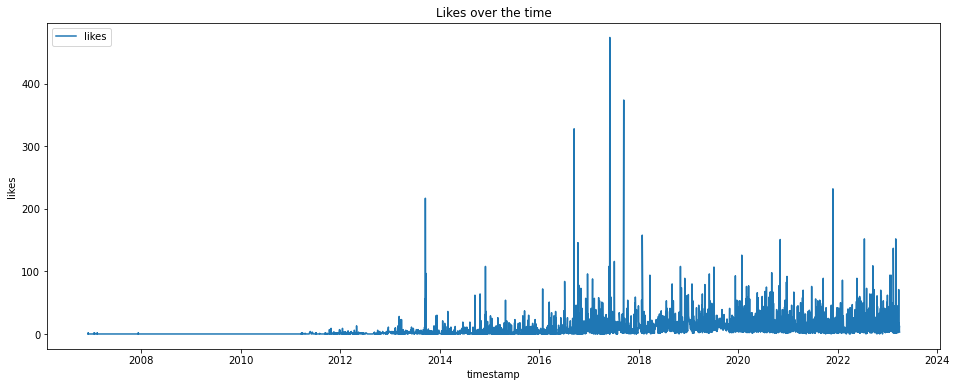

In [75]:
plt.figure(figsize=(16, 6))
plt.plot(time_axis, likes_count)
plt.ylabel('likes')
plt.xlabel('timestamp')
plt.title('Likes over the time')
plt.legend(['likes'], loc='upper left')
plt.show()

In [76]:
# reposts by days
reposts_count = [
    x.items_reposts_count 
    for x in sdf_posts.sort('items_date').select('items_reposts_count').collect()
]

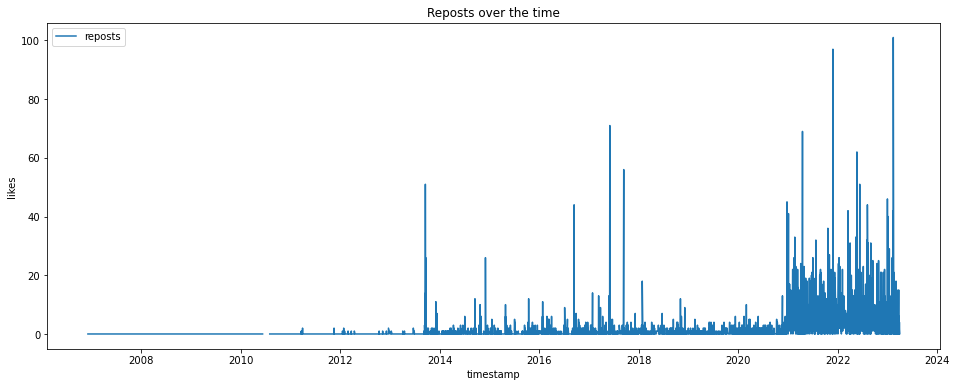

In [77]:
plt.figure(figsize=(16, 6))
plt.plot(time_axis, reposts_count)
plt.ylabel('likes')
plt.xlabel('timestamp')
plt.title('Reposts over the time')
plt.legend(['reposts'], loc='upper left')
plt.show()

In [78]:
# comments by day of week
sdf_posts = sdf_posts.withColumn('items_date_dow', F.dayofweek('items_date'))
sdf_posts.limit(7).toPandas()

,items_date,items_text,items_comments_count,items_likes_count,items_reposts_count,items_date_dow
0,2023-02-01 09:30:08,Интересно поработать над реальным проектом для...,0,14,11,4
1,2007-07-21 19:58:28,Друзья!\nОбъединимся на благо со-студента :)\n...,0,0,0,7
2,2019-01-15 07:20:00,#GSOMstudents\n\nРебята из [club89500784|GSOM ...,0,17,0,3
3,2014-05-18 20:07:12,,0,1,0,1
4,2022-10-14 12:18:12,"В ВШМ СПбГУ работают яркие, разносторонние, та...",4,61,24,6
5,2015-10-08 13:25:06,Наши магистры организуют встречу с СЕО CarPric...,0,6,0,5
6,2015-04-22 10:39:33,,0,2,0,4


In [79]:
comments_dow = sdf_posts.groupBy('items_date_dow').sum().collect()

In [80]:
comments_dow

[Row(items_date_dow=1, sum(items_comments_count)=61, sum(items_likes_count)=1833, sum(items_reposts_count)=188, sum(items_date_dow)=403),
 Row(items_date_dow=6, sum(items_comments_count)=246, sum(items_likes_count)=7687, sum(items_reposts_count)=1467, sum(items_date_dow)=5856),
 Row(items_date_dow=3, sum(items_comments_count)=246, sum(items_likes_count)=8151, sum(items_reposts_count)=1459, sum(items_date_dow)=3360),
 Row(items_date_dow=5, sum(items_comments_count)=260, sum(items_likes_count)=9113, sum(items_reposts_count)=1955, sum(items_date_dow)=5455),
 Row(items_date_dow=4, sum(items_comments_count)=273, sum(items_likes_count)=7918, sum(items_reposts_count)=1508, sum(items_date_dow)=4244),
 Row(items_date_dow=7, sum(items_comments_count)=148, sum(items_likes_count)=3380, sum(items_reposts_count)=435, sum(items_date_dow)=3381),
 Row(items_date_dow=2, sum(items_comments_count)=276, sum(items_likes_count)=9666, sum(items_reposts_count)=1612, sum(items_date_dow)=2152)]

In [81]:
comments_dow = [(x['items_date_dow'], x['sum(items_comments_count)']) for x in comments_dow]
comments_dow

[(1, 61), (6, 246), (3, 246), (5, 260), (4, 273), (7, 148), (2, 276)]

In [82]:
dow = [x[0] for x in comments_dow]
comments = [x[1] for x in comments_dow]

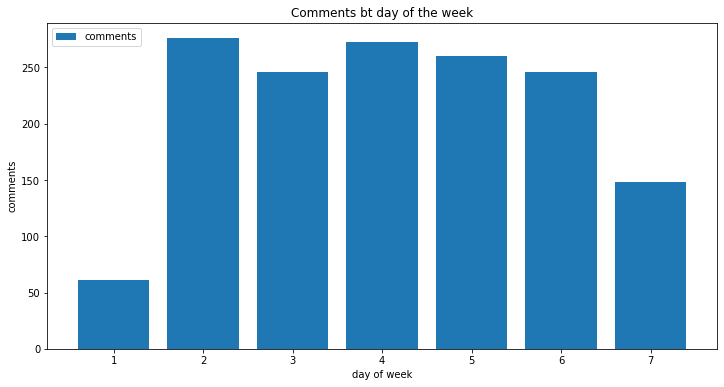

In [83]:
plt.figure(figsize=(12, 6))
plt.bar(dow, comments)
plt.ylabel('comments')
plt.xlabel('day of week')
plt.title('Comments bt day of the week')
plt.legend(['comments'], loc='upper left')
plt.show()